In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

<h2>Read DHS Poverty Data in from Files</h2>

Read in the DHS poverty data into a dataframe       

In [2]:
column_name_dict = {}

with open('BDHR7RDT\BDHR7RFL.DO', 'r') as do_file:
    while line := do_file.readline():
        if 'label variable' in line:
            original_column, new_column = line.split()[2], " ".join(line.split()[3:])[1:-1]
            column_name_dict[original_column] = new_column
dhs_data = pd.read_stata('BDHR7RDT\BDHR7RFL.DTA')
dhs_data = dhs_data.rename(columns=column_name_dict)
dhs_data = dhs_data.dropna(axis=1)


Some columns with data that I explore later on

In [3]:
main_columns = [
    'Cluster number',
    'Has electricity',
    'Has mobile telephone',
    'Wealth index factor score combined (5 decimals)',
    'Education completed in single years',
    'latitude',
    'longitude']

Read in the coordinates of the clusters used in the DHS poverty survey 

In [4]:
cluster_data = pd.read_csv('cluster_data_2017-18.csv')
cluster_coordinates = cluster_data.loc[:, ['DHSCLUST', 'LATNUM', 'LONGNUM']]
cluster_coordinates = cluster_coordinates.rename(mapper = {'DHSCLUST':'Cluster number', 'LATNUM':'latitude', 'LONGNUM':'longitude'}, axis=1)
dhs_data_with_clusters = dhs_data.merge(right=cluster_coordinates, on='Cluster number')
dhs_main = dhs_data_with_clusters.loc[:, main_columns]
dhs_main['Wealth index factor score combined (5 decimals)'] /= 1000
dhs_main.to_csv('dhs_data_2017.csv', index=False)

Fix the categorical variables in the data

In [5]:
map_category_boolean = {'yes': 1, 'no': 0}
dhs_main['Education completed in single years'] = dhs_main['Education completed in single years'].replace(["don't know"], [0])
dhs_main['Education completed in single years'] = dhs_main['Education completed in single years'].astype(int)
dhs_main['Has electricity'] = dhs_main['Has electricity'].map(map_category_boolean).astype(bool)
dhs_main['Has mobile telephone'] = dhs_main['Has mobile telephone'].map(map_category_boolean).astype(bool)

I use median wealth value as the predictor rather than the mean average. In the case of an average, a single high value can greatly increase the average, whilst this would not affect the median value. Then I produce a CSV of the cluster data that will be used for training later on.

In [8]:
wealth = dhs_main.loc[:, ['Cluster number', 'Wealth index factor score combined (5 decimals)']].groupby('Cluster number').median()
variables = dhs_main.loc[:, ['Cluster number', 'Has electricity', 'Has mobile telephone',
    'Education completed in single years']].groupby('Cluster number').sum()

latlong = dhs_main.loc[:, ['Cluster number', 'latitude', 'longitude']].groupby('Cluster number').min() 
cluster_data = wealth.merge(variables, on='Cluster number').merge(latlong, on='Cluster number')
cluster_data.to_csv('new_cluster_data_2017.csv')

Here I do some EDA (Exploratory data analysis) on the data just to see if there are any correlations and how the wealth data is distributed. 

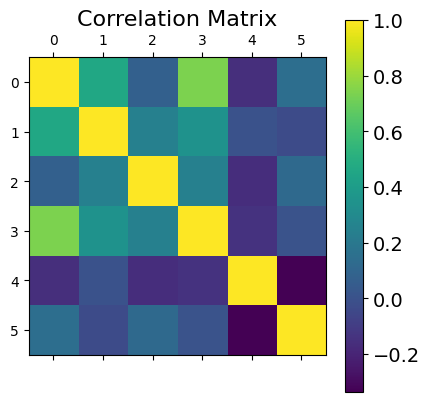

In [7]:
correlations = cluster_data.corr()
plt.matshow(correlations, fignum=10)
plt.title('Correlation Matrix', fontsize=16)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

(array([1222., 7037., 3693., 2366., 1962., 1640., 1046.,  374.,   93.,
          24.]),
 array([-163.452 , -107.7528,  -52.0536,    3.6456,   59.3448,  115.044 ,
         170.7432,  226.4424,  282.1416,  337.8408,  393.54  ]),
 <BarContainer object of 10 artists>)

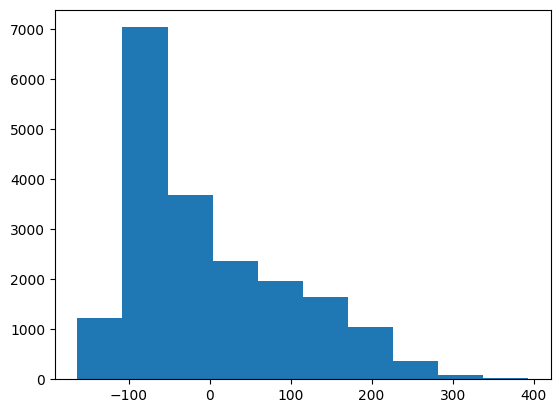

In [8]:
plt.hist(dhs_main['Wealth index factor score combined (5 decimals)'])

Text(0.5, 1.0, 'Electricity')

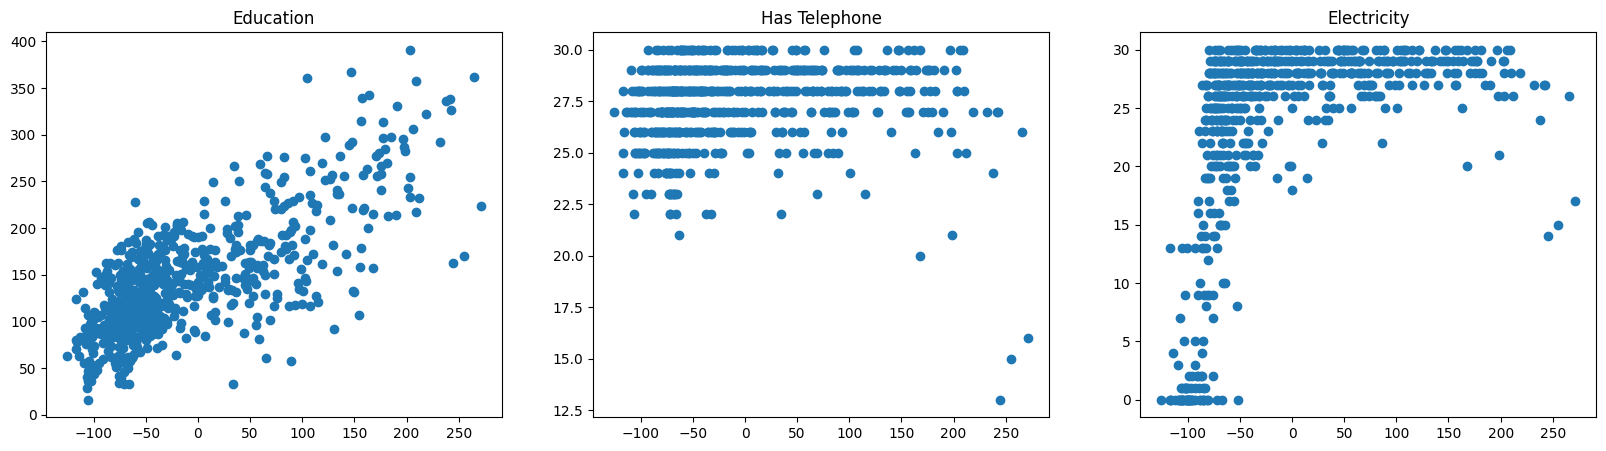

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(cluster_data['Wealth index factor score combined (5 decimals)'], cluster_data['Education completed in single years'])
ax[0].set_title('Education')
ax[1].scatter(cluster_data['Wealth index factor score combined (5 decimals)'], cluster_data['Has mobile telephone'])
ax[1].set_title('Has Telephone')
ax[2].scatter(cluster_data['Wealth index factor score combined (5 decimals)'], cluster_data['Has electricity'])
ax[2].set_title('Electricity')


In [8]:
pd.read_csv('pakistan_clusters_with_nightlights_2017.csv')
pd.read_csv('clusters_with_nightlights_2017.csv')

,Cluster number,Wealth index factor score combined (5 decimals),Has electricity,Has mobile telephone,Education completed in single years,latitude,longitude,Average Nightlight,nightlight bins
0,1,-85.4740,0,29,141,21.907454,90.106474,0.352014,0
1,2,-83.0045,8,29,147,22.171946,90.298709,0.393698,0
2,3,-62.5820,20,29,152,22.167150,90.187479,0.441229,0
3,4,-55.2470,17,30,175,22.195625,90.122065,0.469917,0
4,5,-73.8500,14,27,181,22.348901,90.179272,0.378812,0
...,...,...,...,...,...,...,...,...,...
667,671,206.2805,30,30,306,24.886918,91.877639,8.928744,1
668,672,75.9585,27,30,125,24.901290,91.874433,7.691705,1
669,673,158.7785,30,29,221,24.896535,91.894769,6.860476,1
670,674,100.9100,25,24,133,24.893885,91.894777,6.729105,1
